# Biweekly Report 4

# Jake Watts

# Fast Gradient Signed Method Attack

In this notebook I implement the Fast Gradient Signed Method to attack my trained model from the last report to assess the model's robustness. The model was trained on Cifar-10 data, therefore I will evaluate the effectiveness of this attack by altering Cifar-10 test data to assess the effect on predictionds and model accuracy. I choose epsilon values of .01 and .001 to attack the network and compare accuracy rates.

The Fast Gradient Signed Method is a method of attacking networks in which image pixels changed in the direction of calculated gradients to maximize the loss after forward propogation. This method was proposed in the following paper: https://arxiv.org/pdf/1412.6572.pdf.

In [ ]:
import tensorflow as tf
from keras.datasets import cifar10
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import to_categorical
import matplotlib as mpl
import matplotlib.pyplot as plt
from google.colab import drive
import operator

Mounting my google drive and loading my trained model.

In [ ]:
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
model = load_model('/content/gdrive/My Drive/cifar10_xception_short.h5')

Loading, normalizing and one-hot encoding data. Cifar-10 data.

In [ ]:
def load_data():
  (x_train, y_train), (x_test, y_test) = cifar10.load_data()
  x_train = x_train.astype('float32') / 255
  x_test = x_test.astype('float32') / 255
  y_train = to_categorical(y_train, 10)
  y_test = to_categorical(y_test, 10)
  return (x_train, y_train), (x_test, y_test)

(x_train, y_train), (x_test, y_test) = load_data()

The model without any attacks has an accuracy of approximately 80% on the test data.

In [ ]:
model.evaluate(x_test, y_test)

313/313 [==============================] - 17s 5ms/step - loss: 0.7375 - accuracy: 0.8046


[0.7374982237815857, 0.8046000003814697]

First I will implement the Fast Signed Gradient Method on the first image in the testing data to get a better understanding of how it works.

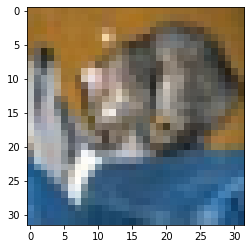

In [ ]:
plt.imshow(x_test[0])

In [ ]:
prediction = model.predict(x_test[0:1]) 

In [ ]:
labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 
          'dog', 'frog', 'horse', 'ship', 'truck']

decoded = dict(zip(labels, prediction[0]))

Without altering the image we see that the trained model identifies the first image correctly as a cat with a value of 0.93. The next closest score to this image is dog with a value of .067 which is considerably smaller.

In [ ]:
decoded

{'airplane': 1.2955362e-08,
 'automobile': 4.8453403e-06,
 'bird': 1.2843896e-06,
 'cat': 0.93257236,
 'deer': 1.5531722e-06,
 'dog': 0.06720104,
 'frog': 0.0002144091,
 'horse': 5.486117e-07,
 'ship': 3.7269176e-06,
 'truck': 5.6176866e-08}

Here I create a function to create the adversarial pattern with the help of a tutorial https://www.tensorflow.org/tutorials/generative/adversarial_fgsm). However the code had to changed somewhat since I am decoding my precictions differently.

In [ ]:
loss_object = tf.keras.losses.CategoricalCrossentropy()

def create_adversarial_pattern(input_image, input_label):
  with tf.GradientTape() as tape:
    tape.watch(input_image)
    prediction = model(input_image)
    loss = loss_object(input_label, prediction)

  # Get the gradients of the loss w.r.t to the input image.
  gradient = tape.gradient(loss, input_image)
  # Get the sign of the gradients to create the perturbation
  signed_grad = tf.sign(gradient)
  return signed_grad

Below are the resulting perturbations created for the first image in the testing data.

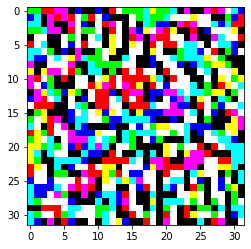

In [ ]:
img = tf.convert_to_tensor(x_test[0:1], dtype=tf.float32)
label = tf.convert_to_tensor(y_test[0:1], dtype=tf.float32)

perturbations = create_adversarial_pattern(img, label)
plt.imshow(perturbations[0] * 0.5 + 0.5);  # To change [-1, 1] to [0,1]

Function for comparing original image and perturbed image predictions.

In [ ]:
def display_images(image, description):
  prediction = model.predict(image)
  decoded = dict(zip(labels, prediction[0]))
  label, confidence = max(decoded.items(), key = operator.itemgetter(1))
  plt.figure()
  plt.imshow(image[0])
  plt.title('{} \n {} : {:.2f}% Confidence'.format(description,
                                                   label, confidence*100))
  plt.show()

Next I mutiply the perturbations by an epsilon of 0.01 and add it to the testing image. While the image does not look different at all to me the prediction changes from 93% confidence of being a cat, which is correct, to 99.97 confidence of a dog.

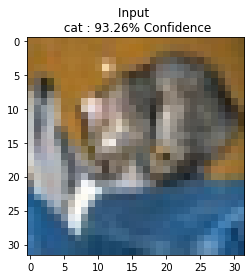

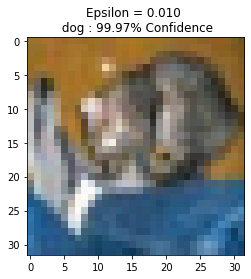

In [ ]:
epsilons = [0, 0.01]
descriptions = [('Epsilon = {:0.3f}'.format(eps) if eps else 'Input')
                for eps in epsilons]

for i, eps in enumerate(epsilons):
  adv_x = img + eps*perturbations
  adv_x = tf.clip_by_value(adv_x, -1, 1)
  display_images(adv_x, descriptions[i])

Applying this attack to the first 10 images in the dataset shiws the same pattern. Every classifcation changes from incorrect to correct after being attacked and the model remains fairly confident even though it is wrong.

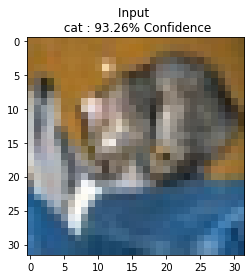

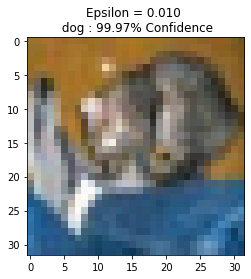

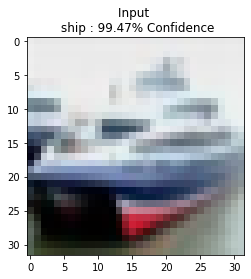

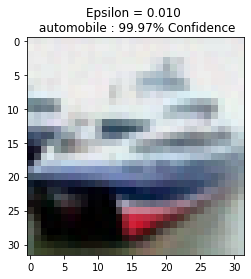

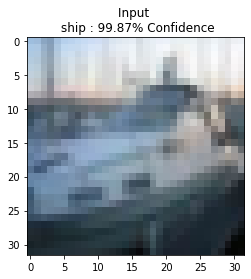

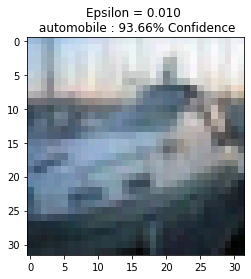

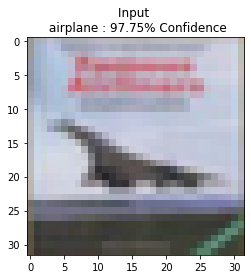

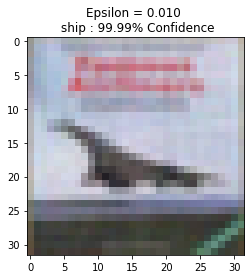

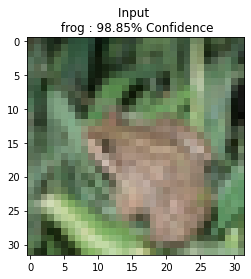

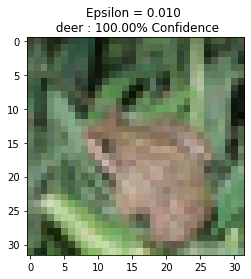

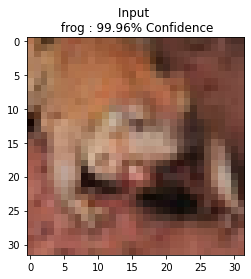

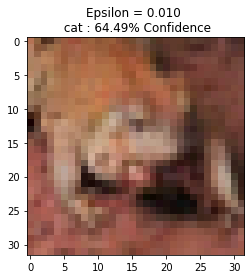

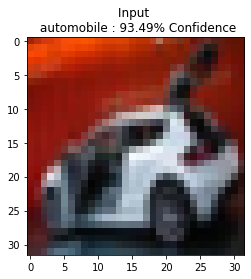

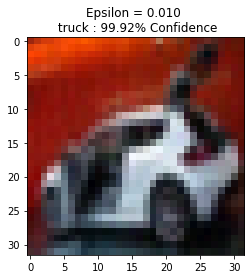

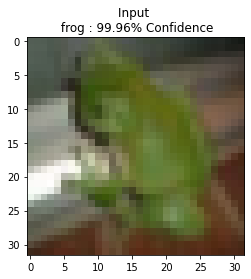

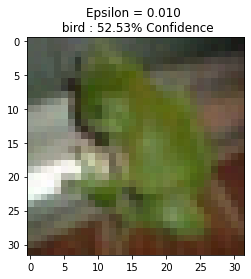

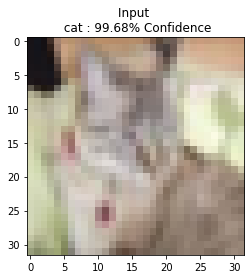

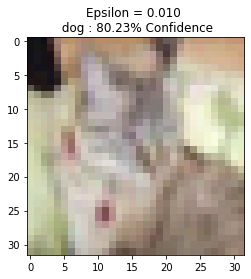

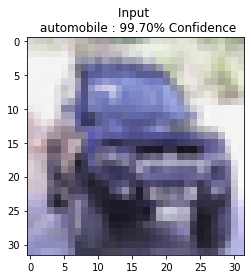

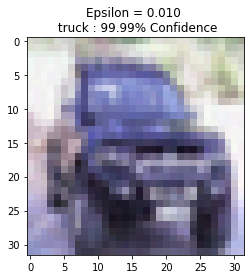

In [ ]:
for i in range(10):

  img = tf.convert_to_tensor(x_test[i:i+1], dtype=tf.float32)
  label = tf.convert_to_tensor(y_test[i:i+1], dtype=tf.float32)
  perturbations = create_adversarial_pattern(img, label)

  epsilons = [0, 0.01]
  descriptions = [('Epsilon = {:0.3f}'.format(eps) if eps else 'Input')
                  for eps in epsilons]

  for i, eps in enumerate(epsilons):
    adv_x = img + eps*perturbations
    adv_x = tf.clip_by_value(adv_x, 0, 1)
    display_images(adv_x, descriptions[i])

Next I perform the perturbations with an epsilon of 0.01 on the first 100 images of the dataset. I only evaluate on 1000 images rather than 10,000 as it the code takes a fair amount of time to run and 1000 images seems sufficient to demonstrate the effects of the attack.



In [ ]:
(x_train, y_train), (x_test, y_test) = load_data()

size = 1000
x_test_attack = x_test[0:size]

for i in range(size):

  img = tf.convert_to_tensor(x_test[i:i+1], dtype=tf.float32)
  label = tf.convert_to_tensor(y_test[i:i+1], dtype=tf.float32)
  perturbations = create_adversarial_pattern(img, label)

  epsilon = 0.01

  x_test_attack[i] = img + epsilon*perturbations
  x_test_attack[i] = tf.clip_by_value(x_test_attack[i], 0, 1)  

The attack is very effective as the accuracy falls from 80% on the original data to 11.1% on the altered data. The model after being attacked is similar to random guessing.

In [ ]:
model.evaluate(x_test_attack, y_test[0:size]) 

32/32 [==============================] - 0s 5ms/step - loss: 8.1852 - accuracy: 0.1110


[8.185211181640625, 0.11100000143051147]

To see if the attack is still effective with an even smaller epsilon, I change it from 0.01 to 0.001 and evaluate on the the first 1000 images. It appears that with an epsilon that is 10 times smaller the attack still makes an impact on the predisctions, causing them accuracy to be about 8% lower than without any attack.

In [ ]:
(x_train, y_train), (x_test, y_test) = load_data()

size = 1000

x_test_attack = x_test[0:size]

for i in range(size):

  img = tf.convert_to_tensor(x_test[i:i+1], dtype=tf.float32)
  label = tf.convert_to_tensor(y_test[i:i+1], dtype=tf.float32)
  perturbations = create_adversarial_pattern(img, label)

  epsilon = 0.001

  x_test_attack[i] = img + epsilon*perturbations
  x_test_attack[i] = tf.clip_by_value(x_test_attack[i], 0, 1)  

model.evaluate(x_test_attack, y_test[0:size])

32/32 [==============================] - 0s 6ms/step - loss: 1.0837 - accuracy: 0.7270


[1.0836848020553589, 0.7269999980926514]

# Summary

In summary this method appears to a very effective way to decrease model accuracy. With an epsilon value of 0.01 the model does not do significantly better than random guessing. Even with an epsilon value 10 times smaller than accuracy of the model decreases from 80% to 72%. 

At both levels of epsilon these changes that largely affect the quality of the model are not perceptible. Therefore my model appears to be susceptible to attacks. 